# Design MERFISH for 4T1 tumor primary

by Pu Zheng

2023.8.20

In [1]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

292198


## Master folder
folder storing all the libraries

In [2]:
library_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes'
print(f"- FISH probe libraries stored in folder: {library_master_folder}")

- FISH probe libraries stored in folder: /lab/solexa_weissman/puzheng/MERFISH_Probes


## References:

GRCm39:
https://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/ 

In [3]:
reference_folder = r'/lab/solexa_weissman/puzheng/References'
print(os.listdir(os.path.join(reference_folder, 'GRCm39', 'Transcriptome')))

['transcriptome_17.table', 'rtRNA_15.table', 'Mus_musculus.GRCm39.ncrna.fa', '.DS_Store', 'Mus_musculus.GRCm39.cdna.all.fa', 'Mus_musculus.GRCm39.109.gff3']


# Define design parameters

## Folders

In [4]:
# Define the output files
library_folder = os.path.join(library_master_folder, '4T1_MERFISH', 'MF9_4T1Lung_mf4plus')
print(f"- library will be saved in: {library_folder}")
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    print(f"-- create library_folder: {library_folder}")
probe_output_file = os.path.join(library_folder, 'designed_probes.csv')
print(f"-- library savefile: {probe_output_file}")
probe_output_idt_file = os.path.join(library_folder, 'designed_probes_idt_oPool.xlsx')
print(f"-- library IDT format savefile: {probe_output_idt_file}")

- library will be saved in: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus
-- library savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/designed_probes.csv
-- library IDT format savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/designed_probes_idt_oPool.xlsx


## Input files:

In [5]:
library_folder

'/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus'

In [6]:
# The output codebook filename
codebook_file = os.path.join(library_folder, 'codebook.csv')
# gene mean expression
target_gene_mean_exp_filename = os.path.join(library_folder, 'marker_gene_mean_exp.csv')
# readout file
readout_savefile = os.path.join(library_folder, 'readouts.csv')

You could also download an example data from:

http://zhuang.harvard.edu/merfish.html

In [7]:
# Define transcriptome reference
mRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                      r'Mus_musculus.GRCm39.cdna.all.fa')
ncRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.ncrna.fa')
gff3_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.109.gff3')

# Define readout sequences
readout_fasta_file = os.path.join(reference_folder, 'Readouts',
                                  r'MERFISH_readouts.fasta')
if os.path.isfile(readout_fasta_file):
    print("readout_fasta_file exists")
else:
    print("readout_fasta_file doesn't exist")
    
# Define primer sequences
forward_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'forward_primers_keep.fasta')
reverse_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'reverse_primers_keep.fasta')
                                   #r'T7_reverse_primers.fasta')
selected_primers_file = os.path.join(library_folder, 'selected_primers.csv')

print(os.path.isfile(forward_primer_file), os.path.isfile(reverse_primer_file))
# Define FPKM reference (Not necessary for smFISH)
fpkm_tracking_file = os.path.join(library_folder, r'isoforms.fpkm_tracking')

readout_fasta_file exists
True True


## Packages

for MERFISH probe design, please refer to package: 
https://github.com/zhengpuas47/MERFISH_probe_design

In [8]:
import numpy as np
import pandas as pd

from IPython.display import display

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot
from MERFISH_probe_design.probe_design import primer_design

# Load designed pd_dict

In [9]:
# candidate probes
import pickle
candidate_probe_filename = os.path.join(library_folder, '2024_10_4_candidate_probe.pkl') # MANUAL CHECK
                                   
print(candidate_probe_filename)
sel_pb_dict = pickle.load(open(candidate_probe_filename, 'rb'))

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/2024_10_4_candidate_probe.pkl


In [10]:
# load kept_genes
kept_gene_filename = os.path.join(library_folder, 'kept_gene_info.csv')
kept_gene_df = pd.read_csv(kept_gene_filename).rename({'Unnamed: 0':'Name'},axis=1).set_index('Name')
print(len(kept_gene_df))

175


In [11]:
sel_pb_dict = {_k:_v for _k,_v in sel_pb_dict.items() if _k in kept_gene_df.index}

In [12]:
p_d.print_probe_dict(sel_pb_dict) 
# We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
Trdc
	ENSMUST00000196323.2	2097
Ighd
	ENSMUST00000194162.6	946
Klhl14
	ENSMUST00000122333.2	2032
Tmem252
	ENSMUST00000057243.6	2293
Gpr141
	ENSMUST00000065335.3	1099
Dab2
	ENSMUST00000080880.12	2101
Epcam
	ENSMUST00000053577.9	846
Msh2
	ENSMUST00000024967.14	1751
Camk4
	ENSMUST00000042868.6	1136
Themis
	ENSMUST00000056097.11	1510
Aicda
	ENSMUST00000043301.14	1274
Cd200r3
	ENSMUST00000114611.10	653
Gata2
	ENSMUST00000015197.9	1603
Btla
	ENSMUST00000102802.10	1123
Serpinf1
	ENSMUST00000000769.14	1090
Myc
	ENSMUST00000161976.8	1245
Ifng
	ENSMUST00000068592.5	524
Cdh1
	ENSMUST00000000312.12	2675
Cd96
	ENSMUST00000023336.10	1162
Cd8b1
	ENSMUST00000065248.9	784
Exosc5
	ENSMUST00000079634.8	651
Cd8a
	ENSMUST00000066747.14	1528
Adgre4
	ENSMUST00000025004.7	1248
Clec14a
	ENSMUST00000062254.4	2030
Cd19
	ENSMUST00000206325.2	1639
Scg2
	ENSMUST00000185234.2	1234
Pou2af1
	ENSMUST00000034554.9	1166
Cd274
	ENSMUST00000016640.8	1693
F7
	ENSMUST00000033820.4	1328
Col5a2
	ENSMUS

In [13]:
print(len(sel_pb_dict))

175


# Load Codebook

In [14]:
# Load the codebook
cb_version, cb_name, bit_names, barcode_table = fio.load_merlin_codebook(codebook_file)
#barcode_table.replace({'name':replace_dict}, inplace=True)
gene_ids = list(kept_gene_df.index)
transcript_ids = set(barcode_table['id'][barcode_table['id'] != '']) # Get the non-blank transcript ids
barcode_table # Let's have a look at the barcode table

,name,id,barcode_str
0,Trdc,ENSMUST00000196323.2,010010000000010010
1,Ighd,ENSMUST00000194162.6,010000100000000110
2,Klhl14,ENSMUST00000122333.2,000101101000000000
3,Tmem252,ENSMUST00000057243.6,001000000001000110
4,Gpr141,ENSMUST00000065335.3,000000010100100010
...,...,...,...
186,Blank-12,,010010000101000000
187,Blank-13,,000001000010011000
188,Blank-14,,000010011000000100
189,Blank-15,,100000000010110000


# Readouts

In [15]:
# load readouts
print(f"Loading readouts from file: {readout_savefile}")
readouts = pd.read_csv(readout_savefile)

Loading readouts from file: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/readouts.csv


In [16]:
# modify Stv into standard sequence
readout_seqs = pd.DataFrame(
    {'id':readouts['Name'], 'description':readouts['Name'], 'sequence':[_s[-20:] for _s in readouts['Sequence']]}
)
rs.append_on_bit_ids_to_readout_sequences(readout_seqs, bit_names)

In [17]:
readout_seqs

,id,description,sequence,on-bit
0,Stv_29,Stv_29,CGGCCGGTTGGTCTACGGAT,0
1,Stv_30,Stv_30,GTCTGGAACGACGGATTCAG,1
2,Stv_31,Stv_31,CGGTGCGGTGGGATGGATAA,2
3,Stv_32,Stv_32,CGTTCGTACCGCGTACTTCG,3
4,Stv_33,Stv_33,AGTGCGCACGAGTTGAACTG,4
5,Stv_35,Stv_35,CGCGGCGTGAATATCGCGGC,5
6,Stv_36,Stv_36,TACGGGCCCAGACGTTTCAT,6
7,Stv_37,Stv_37,GTGTCCGCCAGTACCGTGAG,7
8,Stv_39,Stv_39,CCGTATCCCTGGCGCGGACT,8
9,Stv_40,Stv_40,ACGTAAGGCAGCTTGCGTTA,9


In [18]:
# Add the readout sequences. Here we randomly add 4 readout sequences to each probe.
# Add an "T" between the concatenated sequences.
# Force each probe to have the same readout sequence
num_readouts_per_probe = 3

rs.add_readout_seqs_to_probes_random(sel_pb_dict, readout_seqs, barcode_table, num_readouts_per_probe, 
                                     n_threads=24,
                                     spacer='A', gene_id_key='name', each_probe_1_on_bit=False) 
# if each_probe_1_on_bit set to be true, each probe will have 4 of the same readout sequence

Added readout sequences to 524 probes.
Added readout sequences to 798 probes.
Added readout sequences to 846 probes.
Added readout sequences to 616 probes.
Added readout sequences to 1166 probes.
Added readout sequences to 651 probes.
Added readout sequences to 1274 probes.
Added readout sequences to 432 probes.
Added readout sequences to 834 probes.
Added readout sequences to 1090 probes.
Added readout sequences to 1162 probes.
Added readout sequences to 1157 probes.Added readout sequences to 1099 probes.

Added readout sequences to 653 probes.
Added readout sequences to 1136 probes.
Added readout sequences to 1248 probes.Added readout sequences to 268 probes.

Added readout sequences to 1639 probes.
Added readout sequences to 1328 probes.
Added readout sequences to 1603 probes.
Added readout sequences to 602 probes.
Added readout sequences to 2097 probes.
Added readout sequences to 784 probes.
Added readout sequences to 1751 probes.
Added readout sequences to 2039 probes.
Added reado

In [19]:
%%time
# and minimizes the overlapping between probes.
ps.select_probes_greedy_stochastic(sel_pb_dict, N_probes_per_transcript=96, 
                                   N_on_bits=4, N_threads=24) # manually check N_on_bits
# make this 93 probes because this can fit in 24000 oligo tier

Ifng:ENSMUST00000068592.5: selected 96/524 probes with N_overlapping_bases=3369.0 and on-bit_coverage={9: 73, 17: 71, 14: 71, 7: 73}.
Fgf2:ENSMUST00000138563.9: selected 96/616 probes with N_overlapping_bases=2913.0 and on-bit_coverage={9: 72, 4: 72, 5: 73, 17: 71}.
Exosc5:ENSMUST00000079634.8: selected 96/651 probes with N_overlapping_bases=2950.0 and on-bit_coverage={0: 72, 17: 72, 3: 72, 13: 72}.
Lamp3:ENSMUST00000081880.7: selected 96/798 probes with N_overlapping_bases=1339.0 and on-bit_coverage={1: 74, 10: 70, 11: 70, 15: 74}.
Krt19:ENSMUST00000007317.8: selected 96/834 probes with N_overlapping_bases=1792.0 and on-bit_coverage={1: 72, 10: 72, 4: 72, 7: 72}.
Epcam:ENSMUST00000053577.9: selected 96/846 probes with N_overlapping_bases=1561.0 and on-bit_coverage={16: 70, 9: 73, 4: 72, 15: 73}.
Ly6g:ENSMUST00000190262.2: selected 96/268 probes with N_overlapping_bases=5131.0 and on-bit_coverage={9: 70, 13: 75, 17: 75, 6: 68}.
Serpinf1:ENSMUST00000000769.14: selected 96/1090 probes wi

# Primer

In [20]:
# Load the primer candidates into data frames
forward_primers, reverse_primers = fio.load_primers(forward_primer_file, reverse_primer_file)
display(forward_primers)
display(reverse_primers)

,id,description,sequence,sequence_rc
0,W1A01_primer_0,W1A01_primer_0,CGGCTCGCAGCGTGTAAACG,CGTTTACACGCTGCGAGCCG
1,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG
2,W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG
3,W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG
4,W1A09_primer_8,W1A09_primer_8,TTGTTGAGGCGGCGGAAGTC,GACTTCCGCCGCCTCAACAA
5,W1A11_primer_10,W1A11_primer_10,TTGCTAGCGTGGGCCAATCG,CGATTGGCCCACGCTAGCAA
6,W1B01_primer_12,W1B01_primer_12,TTGGGCGTGCACGTCAATTC,GAATTGACGTGCACGCCCAA
7,W1B03_primer_14,W1B03_primer_14,GACATCCAGGCGCGGACAAC,GTTGTCCGCGCCTGGATGTC
8,W1B05_primer_16,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,GGTGTGCGCAACGAAACCCG
9,W1B07_primer_18,W1B07_primer_18,CACGTGGCCTCTCGCACATC,GATGTGCGAGAGGCCACGTG


,id,description,sequence,sequence_rc
0,W1A02_primer_1,W1A02_primer_1,TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG,CCGCCGGTGATCCTGAAATGCCCTATAGTGAGTCGTATTA
1,W1A04_primer_3,W1A04_primer_3,TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC,GCGTGGAGGGCATACAACGCCCTATAGTGAGTCGTATTA
2,W1A06_primer_5,W1A06_primer_5,TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG,CGGTGCATTTGCGGGAAGACCCTATAGTGAGTCGTATTA
3,W1A08_primer_7,W1A08_primer_7,TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC,GTCGATGCAGCGCGAAAGGGCCCTATAGTGAGTCGTATTA
4,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA
5,W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA
6,W1B04_primer_15,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,TCTTTGGCGCGATGCACAAGCCCTATAGTGAGTCGTATTA
7,W1B06_primer_17,W1B06_primer_17,TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA,TCTCGCGATTTCCGCACAGGCCCTATAGTGAGTCGTATTA
8,W1B10_primer_21,W1B10_primer_21,TAATACGACTCACTATAGGGCGGGTCGATCATCGGCTTTG,CAAAGCCGATGATCGACCCGCCCTATAGTGAGTCGTATTA


In [21]:
# Selet primers
# Make an off-target from the current probe sequences.
ottable_target_readout = ot.get_OTTable_for_probe_dictionary(sel_pb_dict, 'target_readout_sequence', 15)

# Calculate the off-targets for the primer sequences and their reverse-complements
# Usually, there shouln't be any off-targets
ot.calc_OTs_df(forward_primers, ottable_target_readout, 'sequence', 'sequence_OT', 15)
ot.calc_OTs_df(forward_primers, ottable_target_readout, 'sequence_rc', 'sequence_rc_OT', 15)
ot.calc_OTs_df(reverse_primers, ottable_target_readout, 'sequence', 'sequence_OT', 15)
ot.calc_OTs_df(reverse_primers, ottable_target_readout, 'sequence_rc', 'sequence_rc_OT', 15)
# Display primer OT tables to manually select
display(forward_primers)
display(reverse_primers)

,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A01_primer_0,W1A01_primer_0,CGGCTCGCAGCGTGTAAACG,CGTTTACACGCTGCGAGCCG,0,0
1,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG,0,0
2,W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG,0,0
3,W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG,0,0
4,W1A09_primer_8,W1A09_primer_8,TTGTTGAGGCGGCGGAAGTC,GACTTCCGCCGCCTCAACAA,0,0
5,W1A11_primer_10,W1A11_primer_10,TTGCTAGCGTGGGCCAATCG,CGATTGGCCCACGCTAGCAA,0,0
6,W1B01_primer_12,W1B01_primer_12,TTGGGCGTGCACGTCAATTC,GAATTGACGTGCACGCCCAA,0,0
7,W1B03_primer_14,W1B03_primer_14,GACATCCAGGCGCGGACAAC,GTTGTCCGCGCCTGGATGTC,0,0
8,W1B05_primer_16,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,GGTGTGCGCAACGAAACCCG,0,0
9,W1B07_primer_18,W1B07_primer_18,CACGTGGCCTCTCGCACATC,GATGTGCGAGAGGCCACGTG,0,0


,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A02_primer_1,W1A02_primer_1,TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG,CCGCCGGTGATCCTGAAATGCCCTATAGTGAGTCGTATTA,0,0
1,W1A04_primer_3,W1A04_primer_3,TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC,GCGTGGAGGGCATACAACGCCCTATAGTGAGTCGTATTA,0,0
2,W1A06_primer_5,W1A06_primer_5,TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG,CGGTGCATTTGCGGGAAGACCCTATAGTGAGTCGTATTA,0,0
3,W1A08_primer_7,W1A08_primer_7,TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC,GTCGATGCAGCGCGAAAGGGCCCTATAGTGAGTCGTATTA,0,0
4,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA,0,0
5,W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA,0,0
6,W1B04_primer_15,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,TCTTTGGCGCGATGCACAAGCCCTATAGTGAGTCGTATTA,0,0
7,W1B06_primer_17,W1B06_primer_17,TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA,TCTCGCGATTTCCGCACAGGCCCTATAGTGAGTCGTATTA,0,0
8,W1B10_primer_21,W1B10_primer_21,TAATACGACTCACTATAGGGCGGGTCGATCATCGGCTTTG,CAAAGCCGATGATCGACCCGCCCTATAGTGAGTCGTATTA,0,0


In [22]:
# manually select primer:
forward_primers = pd.DataFrame(forward_primers.loc[forward_primers['id']=='W1A03_primer_2'],)
reverse_primers = pd.DataFrame(reverse_primers[reverse_primers['id']=='W1A10_primer_9'], index=None)

## Add the primer sequences

In [23]:
# NOTE: the sequence after primer addition should be (reverse_primer)-(target_readouts)-(forward_primer_rc)
primer_design.add_primer_sequences(sel_pb_dict, 
                                   reverse_primers.iloc[0]['sequence'][-20:], 
                                   forward_primers.iloc[0]['sequence_rc'], ## In this case don't add forward primers at all
                input_column='target_readout_sequence', output_column='target_readout_primer_sequence')

# Notice that the T7 promoter (the first 17 bases of the reverse primer) will be lost after in vitro transcription
# create a column of the T7 transcribed sequences for the subsequent quality check
primer_design.add_primer_sequences(sel_pb_dict, 
                reverse_primers.iloc[0]['sequence'][17:], forward_primers.iloc[0]['sequence_rc'],
                input_column='target_readout_sequence', output_column='target_readout_primer_sequence_t7_transcribed')

In [24]:
print(selected_primers_file)
merged_primer_df = pd.concat([forward_primers, reverse_primers], ignore_index=True)
merged_primer_df.to_csv(selected_primers_file)
merged_primer_df

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/selected_primers.csv


,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG,0,0
1,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA,0,0


# Quality check

In [25]:
sel_pb_dict['Trdc']['ENSMUST00000196323.2']

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence,target_readout_primer_sequence,target_readout_primer_sequence_t7_transcribed
1711,Trdc,ENSMUST00000196323.2,1711,AACAGGCCCTAACAACTCAATACCGTGGTT,46.666667,55.514675,0,1.0,0.01,Stv_30::Stv_46:Stv_53,010000000000010010,GTCTGGAACGACGGATTCAGAAACAGGCCCTAACAACTCAATACCG...,GGATTGCCGCATGGTTTCCGGTCTGGAACGACGGATTCAGAAACAG...,GGGATTGCCGCATGGTTTCCGGTCTGGAACGACGGATTCAGAAACA...
2796,Trdc,ENSMUST00000196323.2,2796,GCTGCAACAAGTGCTAGAAATACAGCATGC,46.666667,52.119099,0,1.0,0.01,Stv_33::Stv_53:Stv_46,000010000000010010,AGTGCGCACGAGTTGAACTGAGCTGCAACAAGTGCTAGAAATACAG...,GGATTGCCGCATGGTTTCCGAGTGCGCACGAGTTGAACTGAGCTGC...,GGGATTGCCGCATGGTTTCCGAGTGCGCACGAGTTGAACTGAGCTG...
3561,Trdc,ENSMUST00000196323.2,3561,GGCATGTGACTTTCTGTGGAAGGGGGATGG,56.666667,57.856972,0,1.0,0.01,Stv_33::Stv_30:Stv_46,010010000000010000,AGTGCGCACGAGTTGAACTGAGGCATGTGACTTTCTGTGGAAGGGG...,GGATTGCCGCATGGTTTCCGAGTGCGCACGAGTTGAACTGAGGCAT...,GGGATTGCCGCATGGTTTCCGAGTGCGCACGAGTTGAACTGAGGCA...
1591,Trdc,ENSMUST00000196323.2,1591,TGTCTAGGGAACTGGGCCCTGGTTTCCTGC,60.000000,61.076511,0,1.0,0.01,Stv_30::Stv_33:Stv_53,010010000000000010,GTCTGGAACGACGGATTCAGATGTCTAGGGAACTGGGCCCTGGTTT...,GGATTGCCGCATGGTTTCCGGTCTGGAACGACGGATTCAGATGTCT...,GGGATTGCCGCATGGTTTCCGGTCTGGAACGACGGATTCAGATGTC...
2112,Trdc,ENSMUST00000196323.2,2112,CAGAGATATGGCTGGAAACGAAACCAAGGT,46.666667,53.300819,0,1.0,0.01,Stv_30::Stv_53:Stv_33,010010000000000010,GTCTGGAACGACGGATTCAGACAGAGATATGGCTGGAAACGAAACC...,GGATTGCCGCATGGTTTCCGGTCTGGAACGACGGATTCAGACAGAG...,GGGATTGCCGCATGGTTTCCGGTCTGGAACGACGGATTCAGACAGA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2771,Trdc,ENSMUST00000196323.2,2771,TTTTGACAACGCCTCCTAGCACGTAGCTGC,53.333333,56.455135,0,1.0,0.01,Stv_46::Stv_53:Stv_30,010000000000010010,CGTCGCGATACTGGTGTAAGATTTTGACAACGCCTCCTAGCACGTA...,GGATTGCCGCATGGTTTCCGCGTCGCGATACTGGTGTAAGATTTTG...,GGGATTGCCGCATGGTTTCCGCGTCGCGATACTGGTGTAAGATTTT...
768,Trdc,ENSMUST00000196323.2,768,CCTTCTTCATTTACCCAGAACTAGGAAGTG,43.333333,50.188507,0,1.0,0.01,Stv_33::Stv_53:Stv_30,010010000000000010,AGTGCGCACGAGTTGAACTGACCTTCTTCATTTACCCAGAACTAGG...,GGATTGCCGCATGGTTTCCGAGTGCGCACGAGTTGAACTGACCTTC...,GGGATTGCCGCATGGTTTCCGAGTGCGCACGAGTTGAACTGACCTT...
448,Trdc,ENSMUST00000196323.2,448,GTTATTCTTTTAAGGTGGGCTGACATGAGG,43.333333,51.034523,0,1.0,0.01,Stv_46::Stv_33:Stv_53,000010000000010010,CGTCGCGATACTGGTGTAAGAGTTATTCTTTTAAGGTGGGCTGACA...,GGATTGCCGCATGGTTTCCGCGTCGCGATACTGGTGTAAGAGTTAT...,GGGATTGCCGCATGGTTTCCGCGTCGCGATACTGGTGTAAGAGTTA...
861,Trdc,ENSMUST00000196323.2,861,AAACATGGAAAGCTGTACTCAACTCATCCC,43.333333,51.336842,0,1.0,0.01,Stv_53::Stv_46:Stv_33,000010000000010010,CGTCGTGGGACGTGGACCGTAAAACATGGAAAGCTGTACTCAACTC...,GGATTGCCGCATGGTTTCCGCGTCGTGGGACGTGGACCGTAAAACA...,GGGATTGCCGCATGGTTTCCGCGTCGTGGGACGTGGACCGTAAAAC...


Calculate OTs for 0/175 genes.
Calculate OTs for 1/175 genes.
Calculate OTs for 2/175 genes.
Calculate OTs for 3/175 genes.
Calculate OTs for 4/175 genes.
Calculate OTs for 5/175 genes.
Calculate OTs for 6/175 genes.
Calculate OTs for 7/175 genes.
Calculate OTs for 8/175 genes.
Calculate OTs for 9/175 genes.
Calculate OTs for 10/175 genes.
Calculate OTs for 11/175 genes.
Calculate OTs for 12/175 genes.
Calculate OTs for 13/175 genes.
Calculate OTs for 14/175 genes.
Calculate OTs for 15/175 genes.
Calculate OTs for 16/175 genes.
Calculate OTs for 17/175 genes.
Calculate OTs for 18/175 genes.
Calculate OTs for 19/175 genes.
Calculate OTs for 20/175 genes.
Calculate OTs for 21/175 genes.
Calculate OTs for 22/175 genes.
Calculate OTs for 23/175 genes.
Calculate OTs for 24/175 genes.
Calculate OTs for 25/175 genes.
Calculate OTs for 26/175 genes.
Calculate OTs for 27/175 genes.
Calculate OTs for 28/175 genes.
Calculate OTs for 29/175 genes.
Calculate OTs for 30/175 genes.
Calculate OTs for 

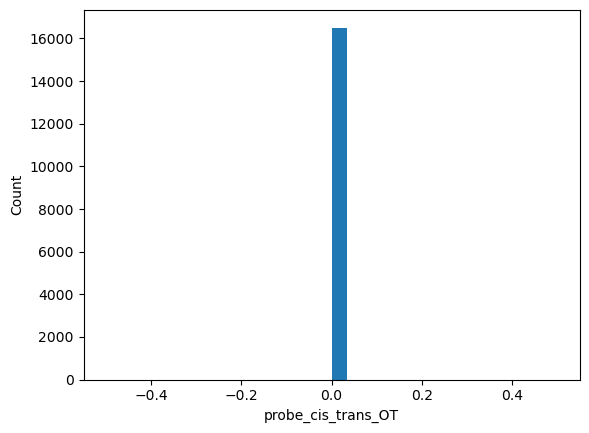

In [26]:
# Iterately remove the probes with high numbers of cis/trans-complementarity
# This filtering strategy is a compromise between speed and the number of probes to keep
while True:
    # Make a OTTable from the reverse-complement sequences of the probes.
    ottable_probes_rc = ot.get_OTTable_for_probe_dictionary(sel_pb_dict, 'target_readout_sequence', 15, rc=True)
    
    # The off-targets in this table indicates cis/trans-complementarity
    ot.calc_OTs(sel_pb_dict, ottable_probes_rc, 'target_readout_sequence', 'probe_cis_trans_OT', 15)
    max_ot = max(plot.get_values_from_probe_dict(sel_pb_dict, 'probe_cis_trans_OT'))
    if max_ot == 0:
        break
    
    # Remove probes that have any cis/trans-complementarity
    filters.filter_probe_dict_by_metric(sel_pb_dict, 'probe_cis_trans_OT', upper_bound=max_ot - 0.5)
    
plot.plot_hist(sel_pb_dict, 'probe_cis_trans_OT')

# Output

## default csv output

In [27]:
# Get the reverse-complementary sequences of the designed probes
p_d.get_rc_sequences(sel_pb_dict, 'target_readout_primer_sequence', 'target_readout_primer_sequence_rc')

# Get a data frame of all probes
df_all_probes = p_d.probe_dict_to_df(sel_pb_dict).sort_values(['probe_barcode', 'shift'])

# Make a column of probe names
probe_names = np.array(df_all_probes['gene_id']) + '_' + np.array(df_all_probes['transcript_id'])
probe_names = probe_names + '_shift:' + np.array(df_all_probes['shift']).astype(str)
probe_names = probe_names + '_GC:' + np.array(df_all_probes['target_GC']).astype('|S4').astype(str)
probe_names = probe_names + '_Tm:' + np.array(df_all_probes['target_Tm']).astype('|S4').astype(str)
probe_names = probe_names + '_specificity:' + np.array(df_all_probes['target_specificity']).astype('|S1').astype(str)
probe_names = probe_names + '_isospecificity:' + np.array(df_all_probes['target_isospecificity']).astype('|S4').astype(str)
probe_names = probe_names + '_' + np.array(df_all_probes['readout_names'])
df_all_probes['probe_names'] = probe_names

# Write the designed probes
print(probe_output_file)
df_all_probes.to_csv(probe_output_file, index=False)

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/designed_probes.csv


In [28]:
len(df_all_probes)

16508

# IDT version output

# Twistbio output with date

In [29]:
import re, time
from Bio.Seq import reverse_complement

In [41]:
twist_final_probes = pd.DataFrame(
    {
        "name": df_all_probes['probe_names'].values,
        "sequence": df_all_probes['target_readout_primer_sequence_rc'].values,
        "library": ['MF9-mf4plus'] * len(df_all_probes),
    }
)
twist_probe_filename = os.path.join(library_folder,
    f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_twist_probes.xlsx")
print(f"saving twist probes to file: {twist_probe_filename}")
twist_final_probes.to_excel(twist_probe_filename, index=None)

saving twist probes to file: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/2024_10_4_twist_probes.xlsx


In [31]:
print(codebook_file)

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/codebook.csv


In [32]:
len(twist_final_probes)

16508

# Split some genes out:

In [39]:
# Load manual_lung_genes:
lung_genes = pd.read_csv(os.path.join(library_folder, 'manual_lung_genes.csv'))['Gene'].values
print(len(lung_genes))

25


In [42]:
main_probes, addon_probes = [], []


## Manual checks:

In [33]:
probe_id = 200
twist_final_probes.loc[probe_id,'name']

'Pdcd1_ENSMUST00000027507.9_shift:702_GC:60.0_Tm:57.9_specificity:1_isospecificity:0.01_Stv_53::Stv_54:Stv_44'

In [34]:
print(len(twist_final_probes.loc[probe_id,'sequence']))

133


### readouts

In [35]:
twist_final_probes.loc[probe_id,'sequence'][20:40],twist_final_probes.loc[probe_id,'sequence'][41:61],twist_final_probes.loc[probe_id,'sequence'][93:113]


('GCCCGCAGTAACGCTCCGAG', 'GGTGTAGTTCTCCGATTGCG', 'ACGGTCCACGTCCCACGACG')

### targeting seq

In [36]:
twist_final_probes.loc[probe_id,'sequence'][62:92] # will ncbi blast this manually

'CACACTAGGGACAGGTGCTGCTGAAGGCTC'

### primers

In [37]:
twist_final_probes.loc[probe_id,'sequence'][:20]

'CCCGCAATGGCTGACAACCG'

In [38]:
twist_final_probes.loc[probe_id,'sequence'][-20:]

'CGGAAACCATGCGGCAATCC'